Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.1 MB/s 
     |████████████████████████████████| 596 kB 90.5 MB/s 
     |████████████████████████████████| 6.6 MB 56.7 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=2201dfe41a2a9d3907a1ad08bd330a6f649459e7fc872805d072a4979fea3328
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['B-Apparatus-Unit', 'B-Operation', 'I-Apparatus-Descriptor', 'I-Operation', 'I-Synthesis-Apparatus', 'I-Property-Type', 'I-Number', 'B-Material-Descriptor', 'I-Nonrecipe-Material', 'B-Brand', 'B-Amount-Unit', 'B-Synthesis-Apparatus', 'B-Number', 'B-Property-Type', 'B-Property-Unit', 'I-Reference', 'B-Property-Misc', 'I-Material-Descriptor', 'I-Amount-Misc', 'I-Meta', 'I-Characterization-Apparatus', 'B-Condition-Type', 'I-Apparatus-Unit', 'B-Nonrecipe-Material', 'B-Condition-Unit', 'I-Condition-Type', 'I-Material', 'B-Condition-Misc', 'I-Property-Misc', 'I-Condition-Misc', 'B-Apparatus-Property-Type', 'O', 'I-Brand', 'B-Apparatus-Descriptor', 'B-Characterization-Apparatus', 'I-Apparatus-Property-Type', 'B-Amount-Misc', 'B-Reference

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

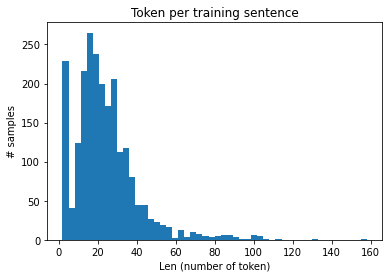

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

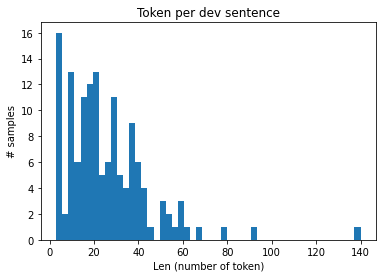

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

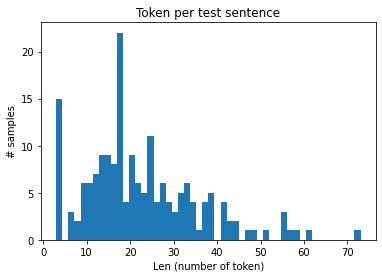

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

5809
ultrafiltration
40
I-Synthesis-Apparatus


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.75)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 563
Points in y_train before removal: 563


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[5469, 5282, 4178, 1157, 5482, 2860, 3942, 2265, 6403, 5044, 1665]
[31, 40, 31, 27, 1, 31, 1, 31, 7, 40, 31]
[825, 4275, 5366]
[31, 31, 31]
[825, 4275, 1407]
[31, 31, 31]
5809
ultrafiltration
40
I-Synthesis-Apparatus
6535
43


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 120 kB 79.0 MB/s 
     |████████████████████████████████| 6.6 MB 44.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=5caeda138d20f5c929312755cd4ff96740cea76a4a4538da799737baeb820fe0
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[5469, 5282, 4178, 1157, 5482, 2860, 3942, 2265, 6403, 5044,

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 563
Points in y_train after augmentation: 563
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.953328847885132
Training loss epoch: 1.6287043889363606
Training accuracy epoch: 0.6540568015810794
Validating model...
Validation Loss: 0.930801272392273
Validation Accuracy: 0.7760799358157474
Training epoch: 2
Training loss per 100 training steps: 0.6979966163635254
Training loss epoch: 0.7545354806241535
Training accuracy epoch: 0.8185699510188451
Validating model...
Validation Loss: 0.6764266312122345
Validation Accuracy: 0.8245188463011003
Training epoch: 3
Training loss per 100 training steps: 0.7502675652503967
Training loss epoch: 0.5262256619476137
Training accuracy epoch: 0.858091444501533
Validating model...
Validation Loss: 0.5916261941194534
Validation Accuracy: 0.8400834010143287
Training epoch: 4
Training loss per 100 training steps: 0.5432218909263611
Training loss epoch: 0.34988648834682645
Training accuracy epoch: 0.9068709697436891
Validating model...
Validation Loss: 0.5422842502593994
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5408079394927392
Validation Accuracy: 0.8490823104865866
Validation duration: 0.018137049999999988 minutes
F1-score (test): 74.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.78      0.91      0.84        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.44      0.59      0.51        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.94      0.90        87
                  Material       0.73      0.84      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8864989280700684
Training loss epoch: 1.6115376637095498
Training accuracy epoch: 0.651586040040941
Validating model...
Validation Loss: 0.9330140888690949
Validation Accuracy: 0.771212109678143
Training epoch: 2
Training loss per 100 training steps: 1.0578187704086304
Training loss epoch: 0.7374525921685355
Training accuracy epoch: 0.8187904905996485
Validating model...
Validation Loss: 0.6697800636291504
Validation Accuracy: 0.8264112405873993
Training epoch: 3
Training loss per 100 training steps: 0.5219927430152893
Training loss epoch: 0.4813568691412608
Training accuracy epoch: 0.870517479553507
Validating model...
Validation Loss: 0.5761224150657653
Validation Accuracy: 0.8408670205580003
Training epoch: 4
Training loss per 100 training steps: 0.3512157201766968
Training loss epoch: 0.3274697420142946
Training accuracy epoch: 0.9103397998273505
Validating model...
Validation Loss: 0.5629713356494903
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5713773713662074
Validation Accuracy: 0.8421767022466996
Validation duration: 0.018158733333333524 minutes
F1-score (test): 74.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.65      0.74      0.69        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.50      0.95      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.92      0.89        87
                  Material       0.68      0.91      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.783287286758423
Training loss epoch: 1.5462243046079363
Training accuracy epoch: 0.6610957411955335
Validating model...
Validation Loss: 0.9175047516822815
Validation Accuracy: 0.7699158140937893
Training epoch: 2
Training loss per 100 training steps: 0.7485044598579407
Training loss epoch: 0.7374195087523687
Training accuracy epoch: 0.8200973821062444
Validating model...
Validation Loss: 0.6702063471078873
Validation Accuracy: 0.830020742345876
Training epoch: 3
Training loss per 100 training steps: 0.47840985655784607
Training loss epoch: 0.4808166807606107
Training accuracy epoch: 0.869841922651395
Validating model...
Validation Loss: 0.5830723404884338
Validation Accuracy: 0.8344980040543133
Training epoch: 4
Training loss per 100 training steps: 0.3795657455921173
Training loss epoch: 0.34426842133204144
Training accuracy epoch: 0.9020515698659402
Validating model...
Validation Loss: 0.5735102593898773
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6178311017843393
Validation Accuracy: 0.8335257438039816
Validation duration: 0.018008033333333628 minutes
F1-score (test): 74.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.74      0.88      0.80        98
      Apparatus-Descriptor       1.00      0.33      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.59      0.59      0.59        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7843241691589355
Training loss epoch: 1.5490774398758298
Training accuracy epoch: 0.6553949741875561
Validating model...
Validation Loss: 0.8940007805824279
Validation Accuracy: 0.7917477986941706
Training epoch: 2
Training loss per 100 training steps: 0.8268030285835266
Training loss epoch: 0.6850391264472689
Training accuracy epoch: 0.8305765499695297
Validating model...
Validation Loss: 0.6354346692562103
Validation Accuracy: 0.8247530500946038
Training epoch: 3
Training loss per 100 training steps: 0.5291033387184143
Training loss epoch: 0.43735511671929134
Training accuracy epoch: 0.883864650577838
Validating model...
Validation Loss: 0.5617141664028168
Validation Accuracy: 0.844384293707712
Training epoch: 4
Training loss per 100 training steps: 0.281879186630249
Training loss epoch: 0.29401000553653356
Training accuracy epoch: 0.9206466117355719
Validating model...
Validation Loss: 0.5721230894327164
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5774022340774536
Validation Accuracy: 0.8482540932155285
Validation duration: 0.018058050000000016 minutes
F1-score (test): 76.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.85      0.93      0.89        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.57      0.74      0.65        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.71      0.89      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.159609317779541
Training loss epoch: 1.6225874509130205
Training accuracy epoch: 0.6416657523457469
Validating model...
Validation Loss: 0.9652758717536927
Validation Accuracy: 0.7670735199434218
Training epoch: 2
Training loss per 100 training steps: 0.8815463185310364
Training loss epoch: 0.7303224347886585
Training accuracy epoch: 0.8211838858692262
Validating model...
Validation Loss: 0.6652994573116302
Validation Accuracy: 0.8293382409772064
Training epoch: 3
Training loss per 100 training steps: 0.42515867948532104
Training loss epoch: 0.4840913187889826
Training accuracy epoch: 0.8738074497074526
Validating model...
Validation Loss: 0.5622020274400711
Validation Accuracy: 0.8427052647349127
Training epoch: 4
Training loss per 100 training steps: 0.40931180119514465
Training loss epoch: 0.34536088648296537
Training accuracy epoch: 0.9038555092092848
Validating model...
Validation Loss: 0.5265461027622222
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.54765863601978
Validation Accuracy: 0.8509348994397796
Validation duration: 0.018002183333334188 minutes
F1-score (test): 75.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.79      0.90      0.84        98
      Apparatus-Descriptor       0.50      0.44      0.47         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.62      0.90      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.91      0.89        87
                  Material       0.69      0.87      0.77       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8860855102539062
Training loss epoch: 1.5505795932951427
Training accuracy epoch: 0.6507627053153372
Validating model...
Validation Loss: 0.9069447040557861
Validation Accuracy: 0.7872750174529092
Training epoch: 2
Training loss per 100 training steps: 0.922754168510437
Training loss epoch: 0.7366216949054173
Training accuracy epoch: 0.8180619910280962
Validating model...
Validation Loss: 0.6823847830295563
Validation Accuracy: 0.8206941036351498
Training epoch: 3
Training loss per 100 training steps: 0.48857036232948303
Training loss epoch: 0.4928008147648403
Training accuracy epoch: 0.8686348711740002
Validating model...
Validation Loss: 0.5694838643074036
Validation Accuracy: 0.841527557181273
Training epoch: 4
Training loss per 100 training steps: 0.4472910165786743
Training loss epoch: 0.3538155945993605
Training accuracy epoch: 0.9057147391088233
Validating model...
Validation Loss: 0.5509373843669891
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5934644983364985
Validation Accuracy: 0.8411822000538601
Validation duration: 0.018326066666666443 minutes
F1-score (test): 74.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.76      0.89      0.82        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.47      0.56      0.51        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.63      0.95      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.94      0.91        87
                  Material       0.72      0.90      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8862721920013428
Training loss epoch: 1.6337771529243106
Training accuracy epoch: 0.6465005100718952
Validating model...
Validation Loss: 0.9489684700965881
Validation Accuracy: 0.7666952305442141
Training epoch: 2
Training loss per 100 training steps: 0.9672073125839233
Training loss epoch: 0.7564577800886971
Training accuracy epoch: 0.8140649228461181
Validating model...
Validation Loss: 0.6639815598726273
Validation Accuracy: 0.8310553307138073
Training epoch: 3
Training loss per 100 training steps: 0.5971233248710632
Training loss epoch: 0.48892184666224886
Training accuracy epoch: 0.8684568342718387
Validating model...
Validation Loss: 0.574830174446106
Validation Accuracy: 0.836387508059319
Training epoch: 4
Training loss per 100 training steps: 0.44751060009002686
Training loss epoch: 0.37183882225127446
Training accuracy epoch: 0.8969166663972743
Validating model...
Validation Loss: 0.5322229981422424
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5378486032669361
Validation Accuracy: 0.853038180058779
Validation duration: 0.0179592833333345 minutes
F1-score (test): 76.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.40      0.44      0.42         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      1.00      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.94      0.89        87
                  Material       0.72      0.88      0.79       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.029034614562988
Training loss epoch: 1.6043994653792608
Training accuracy epoch: 0.6517054759214138
Validating model...
Validation Loss: 0.8855963468551635
Validation Accuracy: 0.7953734695040252
Training epoch: 2
Training loss per 100 training steps: 0.8088693618774414
Training loss epoch: 0.7501822653270903
Training accuracy epoch: 0.8118530278365308
Validating model...
Validation Loss: 0.6928544342517853
Validation Accuracy: 0.8160169787306801
Training epoch: 3
Training loss per 100 training steps: 0.6333719491958618
Training loss epoch: 0.515674875605674
Training accuracy epoch: 0.8662361698348012
Validating model...
Validation Loss: 0.5529951840639115
Validation Accuracy: 0.850258101478984
Training epoch: 4
Training loss per 100 training steps: 0.5423761606216431
Training loss epoch: 0.35677055588790346
Training accuracy epoch: 0.9040603406006249
Validating model...
Validation Loss: 0.5188497096300125
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5478697533790882
Validation Accuracy: 0.8481477413811548
Validation duration: 0.017936549999999822 minutes
F1-score (test): 75.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.77      0.90      0.83        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.71      0.89      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.130095481872559
Training loss epoch: 1.6343114943731398
Training accuracy epoch: 0.6368528013165297
Validating model...
Validation Loss: 0.9232093751430511
Validation Accuracy: 0.7687679247712472
Training epoch: 2
Training loss per 100 training steps: 0.9253840446472168
Training loss epoch: 0.7188935294037774
Training accuracy epoch: 0.8249296047358028
Validating model...
Validation Loss: 0.6707677960395813
Validation Accuracy: 0.8316910455979581
Training epoch: 3
Training loss per 100 training steps: 0.4927515387535095
Training loss epoch: 0.4738863834312984
Training accuracy epoch: 0.8735246231336878
Validating model...
Validation Loss: 0.5685610234737396
Validation Accuracy: 0.8410112448571633
Training epoch: 4
Training loss per 100 training steps: 0.3301812708377838
Training loss epoch: 0.32880200374694096
Training accuracy epoch: 0.9144381805713405
Validating model...
Validation Loss: 0.5702327102422714
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5762832669111398
Validation Accuracy: 0.8469825009253152
Validation duration: 0.018150216666667045 minutes
F1-score (test): 75.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.85      0.89      0.87        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.79      0.81      0.80        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.69      0.88      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9380342960357666
Training loss epoch: 1.6426869346981956
Training accuracy epoch: 0.6390351751230173
Validating model...
Validation Loss: 0.9569219946861267
Validation Accuracy: 0.7598179491289573
Training epoch: 2
Training loss per 100 training steps: 1.0094163417816162
Training loss epoch: 0.7400337556997935
Training accuracy epoch: 0.8155440999409446
Validating model...
Validation Loss: 0.6764463096857071
Validation Accuracy: 0.8340237534271688
Training epoch: 3
Training loss per 100 training steps: 0.5234360694885254
Training loss epoch: 0.4753763349283309
Training accuracy epoch: 0.877134928148695
Validating model...
Validation Loss: 0.5779289096593857
Validation Accuracy: 0.8436418521050033
Training epoch: 4
Training loss per 100 training steps: 0.32148122787475586
Training loss epoch: 0.32466811935106915
Training accuracy epoch: 0.9143363163613216
Validating model...
Validation Loss: 0.552083307504654
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5687312185764313
Validation Accuracy: 0.8446444434601246
Validation duration: 0.018089866666665937 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.94      0.87        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.70      0.87      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9119954109191895
Training loss epoch: 1.501830897547982
Training accuracy epoch: 0.6676117543275631
Validating model...
Validation Loss: 0.8751767456531525
Validation Accuracy: 0.792527876890673
Training epoch: 2
Training loss per 100 training steps: 0.7396487593650818
Training loss epoch: 0.6769717769189314
Training accuracy epoch: 0.8306482998526366
Validating model...
Validation Loss: 0.6232992738485337
Validation Accuracy: 0.8393041889794285
Training epoch: 3
Training loss per 100 training steps: 0.470939576625824
Training loss epoch: 0.43628865344957873
Training accuracy epoch: 0.8833415065816901
Validating model...
Validation Loss: 0.5419659882783889
Validation Accuracy: 0.8517220337411058
Training epoch: 4
Training loss per 100 training steps: 0.31862160563468933
Training loss epoch: 0.30604585056955164
Training accuracy epoch: 0.9168937360021111
Validating model...
Validation Loss: 0.548499470949173
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6267818487607516
Validation Accuracy: 0.840314037407438
Validation duration: 0.017940500000001216 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.56      0.56      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.53      0.67      0.59        27
Characterization-Apparatus       0.22      0.18      0.20        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.95      0.91        87
                  Material       0.72      0.87      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8725533485412598
Training loss epoch: 1.557823882861571
Training accuracy epoch: 0.6568711062980407
Validating model...
Validation Loss: 0.908979594707489
Validation Accuracy: 0.7835810087650608
Training epoch: 2
Training loss per 100 training steps: 0.9787729382514954
Training loss epoch: 0.7155156514861367
Training accuracy epoch: 0.8214548169101228
Validating model...
Validation Loss: 0.6528630256652832
Validation Accuracy: 0.8309309371167597
Training epoch: 3
Training loss per 100 training steps: 0.4913107454776764
Training loss epoch: 0.46038718521595
Training accuracy epoch: 0.8769108478629204
Validating model...
Validation Loss: 0.5708320289850235
Validation Accuracy: 0.8363154812925334
Training epoch: 4
Training loss per 100 training steps: 0.33994609117507935
Training loss epoch: 0.3040020330385728
Training accuracy epoch: 0.9168024788842665
Validating model...
Validation Loss: 0.5230715692043304
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5486440452245566
Validation Accuracy: 0.850641399675427
Validation duration: 0.017923350000000938 minutes
F1-score (test): 75.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.81      0.92      0.86        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.86      0.46      0.60        13
                     Brand       0.53      0.59      0.56        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.47      0.85      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.70      0.86      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.833918809890747
Training loss epoch: 1.6270017949017612
Training accuracy epoch: 0.6519737336360785
Validating model...
Validation Loss: 0.9595963597297669
Validation Accuracy: 0.7603815730501442
Training epoch: 2
Training loss per 100 training steps: 0.8881343603134155
Training loss epoch: 0.7280189422043887
Training accuracy epoch: 0.8223887692606902
Validating model...
Validation Loss: 0.6598863124847412
Validation Accuracy: 0.8323272352256248
Training epoch: 3
Training loss per 100 training steps: 0.5104315876960754
Training loss epoch: 0.46896539628505707
Training accuracy epoch: 0.8746224894370055
Validating model...
Validation Loss: 0.5656415373086929
Validation Accuracy: 0.8473870438443944
Training epoch: 4
Training loss per 100 training steps: 0.3559999465942383
Training loss epoch: 0.31595851277763193
Training accuracy epoch: 0.9135067959083719
Validating model...
Validation Loss: 0.5205092966556549
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5460201650857925
Validation Accuracy: 0.8445619711575874
Validation duration: 0.017967766666667256 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.85      0.94      0.89        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.59      0.70      0.64        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.59      0.95      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.71      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0046563148498535
Training loss epoch: 1.600651965899901
Training accuracy epoch: 0.6488503790050246
Validating model...
Validation Loss: 0.941461831331253
Validation Accuracy: 0.7755556413441883
Training epoch: 2
Training loss per 100 training steps: 0.7816199660301208
Training loss epoch: 0.7177289507605813
Training accuracy epoch: 0.8222905911021514
Validating model...
Validation Loss: 0.6454057812690734
Validation Accuracy: 0.8334218745233681
Training epoch: 3
Training loss per 100 training steps: 0.5970883369445801
Training loss epoch: 0.4607812084934928
Training accuracy epoch: 0.8756783769068331
Validating model...
Validation Loss: 0.5456770628690719
Validation Accuracy: 0.8462600097704742
Training epoch: 4
Training loss per 100 training steps: 0.2618136703968048
Training loss epoch: 0.30913669954646716
Training accuracy epoch: 0.9173012818526186
Validating model...
Validation Loss: 0.5390196561813354
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5772564869660598
Validation Accuracy: 0.8454448475506713
Validation duration: 0.017899466666669164 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.90      0.93      0.91        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.53      0.63      0.58        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.70      0.85      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8013174533843994
Training loss epoch: 1.5121113847602496
Training accuracy epoch: 0.6714712669871401
Validating model...
Validation Loss: 0.8553393363952637
Validation Accuracy: 0.7983828526294098
Training epoch: 2
Training loss per 100 training steps: 0.9713483452796936
Training loss epoch: 0.7029377086596056
Training accuracy epoch: 0.8254148083770676
Validating model...
Validation Loss: 0.6507327437400818
Validation Accuracy: 0.8347826386019055
Training epoch: 3
Training loss per 100 training steps: 0.5459416508674622
Training loss epoch: 0.44262906231663446
Training accuracy epoch: 0.8822941261971166
Validating model...
Validation Loss: 0.5375401258468628
Validation Accuracy: 0.8514819364545051
Training epoch: 4
Training loss per 100 training steps: 0.3237398862838745
Training loss epoch: 0.28678804636001587
Training accuracy epoch: 0.9245779029289184
Validating model...
Validation Loss: 0.5010043889284134
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5621816699321454
Validation Accuracy: 0.8498150475315673
Validation duration: 0.017964433333334758 minutes
F1-score (test): 76.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.85      0.94      0.89        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.56      0.67      0.61        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.94      0.92        87
                  Material       0.71      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.085768699645996
Training loss epoch: 1.616353988647461
Training accuracy epoch: 0.6436661560087462
Validating model...
Validation Loss: 0.9389975368976593
Validation Accuracy: 0.7734072129343607
Training epoch: 2
Training loss per 100 training steps: 0.8866662979125977
Training loss epoch: 0.7434790269895033
Training accuracy epoch: 0.817031431911709
Validating model...
Validation Loss: 0.6557699888944626
Validation Accuracy: 0.8329733700747479
Training epoch: 3
Training loss per 100 training steps: 0.561019778251648
Training loss epoch: 0.49590643563053827
Training accuracy epoch: 0.8688784152330356
Validating model...
Validation Loss: 0.6495084166526794
Validation Accuracy: 0.8315841945567142
Training epoch: 4
Training loss per 100 training steps: 0.388508677482605
Training loss epoch: 0.3592641238461841
Training accuracy epoch: 0.8992348851898591
Validating model...
Validation Loss: 0.5613710582256317
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5631163395368136
Validation Accuracy: 0.8605577802327897
Validation duration: 0.018065133333334416 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.71      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 704
Points in y_train after augmentation: 704
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8152050971984863
Training loss epoch: 1.5583693141287023
Training accuracy epoch: 0.6660297513891247
Validating model...
Validation Loss: 0.898743736743927
Validation Accuracy: 0.7747481220495644
Training epoch: 2
Training loss per 100 training steps: 0.9153701663017273
Training loss epoch: 0.7104033746502616
Training accuracy epoch: 0.8236182027663563
Validating model...
Validation Loss: 0.6510584950447083
Validation Accuracy: 0.8262016278586083
Training epoch: 3
Training loss per 100 training steps: 0.4640146493911743
Training loss epoch: 0.4391981918703426
Training accuracy epoch: 0.8829894295226933
Validating model...
Validation Loss: 0.5441208362579346
Validation Accuracy: 0.8461505743180424
Training epoch: 4
Training loss per 100 training steps: 0.3044402599334717
Training loss epoch: 0.2835134105248885
Training accuracy epoch: 0.9223615093246185
Validating model...
Validation Loss: 0.5176269769668579
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5642538918898656
Validation Accuracy: 0.8439063376554228
Validation duration: 0.017625683333335473 minutes
F1-score (test): 74.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.80      0.90      0.85        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.92      0.89        87
                  Material       0.71      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.782846450805664
Training loss epoch: 1.6170069060542367
Training accuracy epoch: 0.6497130429481816
Validating model...
Validation Loss: 0.9313510954380035
Validation Accuracy: 0.7776075191927077
Training epoch: 2
Training loss per 100 training steps: 1.0688260793685913
Training loss epoch: 0.7341616397554224
Training accuracy epoch: 0.8169553767596334
Validating model...
Validation Loss: 0.6461294561624527
Validation Accuracy: 0.8285767684609014
Training epoch: 3
Training loss per 100 training steps: 0.4650060534477234
Training loss epoch: 0.4654343832622875
Training accuracy epoch: 0.8762819236206517
Validating model...
Validation Loss: 0.5171872347593307
Validation Accuracy: 0.8537308197719413
Training epoch: 4
Training loss per 100 training steps: 0.27405139803886414
Training loss epoch: 0.29463487592610443
Training accuracy epoch: 0.9200277603006012
Validating model...
Validation Loss: 0.5345721185207367
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5660066489989941
Validation Accuracy: 0.8407292058806765
Validation duration: 0.017934999999999944 minutes
F1-score (test): 72.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.70      0.89      0.78        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.54      0.52      0.53        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.94      0.90        87
                  Material       0.66      0.89      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Device:  cuda
Training epoch: 1
Training loss per 100 training steps: 3.55698561668396
Training loss epoch: 1.5548659292134372
Training accuracy epoch: 0.6476788412477529
Validating model...
Validation Loss: 0.9738010585308075
Validation Accuracy: 0.7623463484900335
Training epoch: 2
Training loss per 100 training steps: 0.9272117018699646
Training loss epoch: 0.7404527880928733
Training accuracy epoch: 0.8204939323319164
Validating model...
Validation Loss: 0.6630416482686996
Validation Accuracy: 0.832215612845201
Training epoch: 3
Training loss per 100 training steps: 0.5285342335700989
Training loss epoch: 0.4896112233400345
Training accuracy epoch: 0.8718317072228938
Validating model...
Validation Loss: 0.5726090222597122
Validation Accuracy: 0.8354756331821669
Training epoch: 4
Training loss per 100 training steps: 0.3790532648563385
Training loss epoch: 0.35265311192382465
Training accuracy epoch: 0.8985511502213716
Validating model...
Validation Loss: 0.4901138454675674
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5246799358954797
Validation Accuracy: 0.8485235442437975
Validation duration: 0.01786941666666356 minutes
F1-score (test): 75.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.70      0.95      0.81        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.93      0.91        87
                  Material       0.70      0.87      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Points in y_train after augmentation: 704
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.822770833969116
Training loss epoch: 1.5070877454497598
Training accuracy epoch: 0.6640157941669362
Validating model...
Validation Loss: 0.8787447214126587
Validation Accuracy: 0.789701909373713
Training epoch: 2
Training loss per 100 training steps: 1.0007902383804321
Training loss epoch: 0.6906310563737695
Training accuracy epoch: 0.8258155842932101
Validating model...
Validation Loss: 0.6572092294692993
Validation Accuracy: 0.8268011505837842
Training epoch: 3
Training loss per 100 training steps: 0.6477304697036743
Training loss epoch: 0.44390785829587415
Training accuracy epoch: 0.8795455237274329
Validating model...
Validation Loss: 0.5670108705759048
Validation Accuracy: 0.8517799485600748
Training epoch: 4
Training loss per 100 training steps: 0.37570756673812866
Training loss epoch: 0.29702436991713266
Training accuracy epoch: 0.9180279594329895
Validating model...
Validation Loss: 0.5559115618467331
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5956684717765222
Validation Accuracy: 0.8341679672707538
Validation duration: 0.017522266666666533 minutes
F1-score (test): 74.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.83      0.93      0.87        98
      Apparatus-Descriptor       0.30      0.33      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.53      0.67      0.59        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.45      1.00      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.73      0.87      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6162147521972656
Training loss epoch: 1.4183506546197113
Training accuracy epoch: 0.683663858410543
Validating model...
Validation Loss: 0.8095054268836975
Validation Accuracy: 0.814393489722591
Training epoch: 2
Training loss per 100 training steps: 0.628942608833313
Training loss epoch: 0.616229972353688
Training accuracy epoch: 0.8434956812863464
Validating model...
Validation Loss: 0.574463176727295
Validation Accuracy: 0.8496670736299496
Training epoch: 3
Training loss per 100 training steps: 0.39940983057022095
Training loss epoch: 0.37781886370093737
Training accuracy epoch: 0.8948757969415294
Validating model...
Validation Loss: 0.5109313279390335
Validation Accuracy: 0.858303728406091
Training epoch: 4
Training loss per 100 training steps: 0.25822338461875916
Training loss epoch: 0.2358633296357261
Training accuracy epoch: 0.9351608620568759
Validating model...
Validation Loss: 0.5147107496857644
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5747297956393316
Validation Accuracy: 0.8564243806591347
Validation duration: 0.017599600000001676 minutes
F1-score (test): 77.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.91      0.93      0.92        98
      Apparatus-Descriptor       0.56      0.56      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.71      0.89      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.978663682937622
Training loss epoch: 1.4572784503300984
Training accuracy epoch: 0.6766904038504066
Validating model...
Validation Loss: 0.8589106261730194
Validation Accuracy: 0.7926005907146461
Training epoch: 2
Training loss per 100 training steps: 0.772514820098877
Training loss epoch: 0.6233313194027653
Training accuracy epoch: 0.8395625296384019
Validating model...
Validation Loss: 0.5767772942781448
Validation Accuracy: 0.8401320984280597
Training epoch: 3
Training loss per 100 training steps: 0.3700278401374817
Training loss epoch: 0.3787648677825928
Training accuracy epoch: 0.8936693317432679
Validating model...
Validation Loss: 0.5040881037712097
Validation Accuracy: 0.8580169750972304
Training epoch: 4
Training loss per 100 training steps: 0.2598824203014374
Training loss epoch: 0.2437855198427483
Training accuracy epoch: 0.932704786129812
Validating model...
Validation Loss: 0.5006624668836593
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5584419621871068
Validation Accuracy: 0.838220078142554
Validation duration: 0.019256749999999555 minutes
F1-score (test): 75.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.85      0.92      0.88        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.65      0.74      0.69        27
Characterization-Apparatus       0.10      0.09      0.10        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.93      0.90        87
                  Material       0.71      0.88      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.853928327560425
Training loss epoch: 1.4188298296045374
Training accuracy epoch: 0.6812240824887205
Validating model...
Validation Loss: 0.830626255273819
Validation Accuracy: 0.8010116267806777
Training epoch: 2
Training loss per 100 training steps: 0.7363476157188416
Training loss epoch: 0.596932613187366
Training accuracy epoch: 0.849646760913574
Validating model...
Validation Loss: 0.5825110107660294
Validation Accuracy: 0.842445252437441
Training epoch: 3
Training loss per 100 training steps: 0.4434734880924225
Training loss epoch: 0.35810997033560715
Training accuracy epoch: 0.9007743434172019
Validating model...
Validation Loss: 0.5231847375631332
Validation Accuracy: 0.8572009764344223
Training epoch: 4
Training loss per 100 training steps: 0.3189297020435333
Training loss epoch: 0.23939461840523613
Training accuracy epoch: 0.9333375245676773
Validating model...
Validation Loss: 0.566445255279541
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5299226733354422
Validation Accuracy: 0.8508553424445512
Validation duration: 0.01784501666666832 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.82      0.91      0.86        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.75      0.67      0.71        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.45      0.90      0.60        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.91      0.88        87
                  Material       0.76      0.84      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.874971389770508
Training loss epoch: 1.4246655680515148
Training accuracy epoch: 0.6806219026641571
Validating model...
Validation Loss: 0.8325433254241943
Validation Accuracy: 0.801384655175409
Training epoch: 2
Training loss per 100 training steps: 0.8825700879096985
Training loss epoch: 0.6265967532440468
Training accuracy epoch: 0.841658611194693
Validating model...
Validation Loss: 0.6066302210092545
Validation Accuracy: 0.8393866739393596
Training epoch: 3
Training loss per 100 training steps: 0.4778285324573517
Training loss epoch: 0.3744550402517672
Training accuracy epoch: 0.8984114271239034
Validating model...
Validation Loss: 0.5626242607831955
Validation Accuracy: 0.8477599981118473
Training epoch: 4
Training loss per 100 training steps: 0.27809372544288635
Training loss epoch: 0.2375911435595265
Training accuracy epoch: 0.936183566017529
Validating model...
Validation Loss: 0.5358150333166123
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5567472210297217
Validation Accuracy: 0.8532354144611995
Validation duration: 0.017998049999998027 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.56      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.67      0.67      0.67        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.89      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8619191646575928
Training loss epoch: 1.4465203241065696
Training accuracy epoch: 0.6789115397853379
Validating model...
Validation Loss: 0.8255183160305023
Validation Accuracy: 0.801884016709727
Training epoch: 2
Training loss per 100 training steps: 0.7512533068656921
Training loss epoch: 0.6356976253015024
Training accuracy epoch: 0.8377205761131971
Validating model...
Validation Loss: 0.5919552594423294
Validation Accuracy: 0.8429986881578776
Training epoch: 3
Training loss per 100 training steps: 0.43987029790878296
Training loss epoch: 0.39689843080661913
Training accuracy epoch: 0.8907516569655316
Validating model...
Validation Loss: 0.5107557237148285
Validation Accuracy: 0.8562372942216484
Training epoch: 4
Training loss per 100 training steps: 0.29525476694107056
Training loss epoch: 0.2439768816585894
Training accuracy epoch: 0.9345586350706246
Validating model...
Validation Loss: 0.5135071337223053
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.609188219675651
Validation Accuracy: 0.8460547489110068
Validation duration: 0.017833866666668047 minutes
F1-score (test): 76.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.80      0.44      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.47      1.00      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.72      0.87      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9144532680511475
Training loss epoch: 1.427813986937205
Training accuracy epoch: 0.686858680344285
Validating model...
Validation Loss: 0.8321817994117737
Validation Accuracy: 0.8000951553154122
Training epoch: 2
Training loss per 100 training steps: 0.6965786814689636
Training loss epoch: 0.6015126815548649
Training accuracy epoch: 0.8484915288125339
Validating model...
Validation Loss: 0.5999468088150024
Validation Accuracy: 0.8403229375503203
Training epoch: 3
Training loss per 100 training steps: 0.4008142054080963
Training loss epoch: 0.3677230256575125
Training accuracy epoch: 0.9007383704213162
Validating model...
Validation Loss: 0.5333241164684296
Validation Accuracy: 0.8571134119287283
Training epoch: 4
Training loss per 100 training steps: 0.2290922999382019
Training loss epoch: 0.22903180398322917
Training accuracy epoch: 0.9398302099277575
Validating model...
Validation Loss: 0.49999583661556246
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5467485120663276
Validation Accuracy: 0.8489351969199864
Validation duration: 0.017897866666665627 minutes
F1-score (test): 76.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.50      0.56      0.53        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.49      1.00      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.008813858032227
Training loss epoch: 1.4344888152899566
Training accuracy epoch: 0.6802704709431777
Validating model...
Validation Loss: 0.8653374552726746
Validation Accuracy: 0.7847405978046766
Training epoch: 2
Training loss per 100 training steps: 0.7907300591468811
Training loss epoch: 0.6136069628927443
Training accuracy epoch: 0.8438689366811124
Validating model...
Validation Loss: 0.5771497577428818
Validation Accuracy: 0.8467198522806288
Training epoch: 3
Training loss per 100 training steps: 0.4792344868183136
Training loss epoch: 0.37617000219998536
Training accuracy epoch: 0.8981519462939864
Validating model...
Validation Loss: 0.5164065152406693
Validation Accuracy: 0.8558500716535515
Training epoch: 4
Training loss per 100 training steps: 0.2434971034526825
Training loss epoch: 0.2417209181520674
Training accuracy epoch: 0.9344610018798156
Validating model...
Validation Loss: 0.510148698091507
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5344704618820777
Validation Accuracy: 0.8463112487207387
Validation duration: 0.017776949999999184 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.14      0.15         7
               Amount-Unit       0.87      0.95      0.91        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.72      0.84      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.028337001800537
Training loss epoch: 1.5200898978445265
Training accuracy epoch: 0.6667260755717889
Validating model...
Validation Loss: 0.8492276251316071
Validation Accuracy: 0.7941326364057113
Training epoch: 2
Training loss per 100 training steps: 0.874910295009613
Training loss epoch: 0.6619211733341217
Training accuracy epoch: 0.8291229590067134
Validating model...
Validation Loss: 0.5961264401674271
Validation Accuracy: 0.831146014310924
Training epoch: 3
Training loss per 100 training steps: 0.42318716645240784
Training loss epoch: 0.38049354321426815
Training accuracy epoch: 0.894039760031015
Validating model...
Validation Loss: 0.5355440527200699
Validation Accuracy: 0.8442664068377284
Training epoch: 4
Training loss per 100 training steps: 0.3353704512119293
Training loss epoch: 0.24596203477294357
Training accuracy epoch: 0.9341987694671029
Validating model...
Validation Loss: 0.5424447685480118
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5601775394036219
Validation Accuracy: 0.84044663954149
Validation duration: 0.01784341666666478 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.50      0.29      0.36         7
               Amount-Unit       0.83      0.93      0.87        98
      Apparatus-Descriptor       0.42      0.56      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.57      0.63      0.60        27
Characterization-Apparatus       0.12      0.09      0.11        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.69      0.84      0.76       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8098013401031494
Training loss epoch: 1.4105776482158237
Training accuracy epoch: 0.6827392068346745
Validating model...
Validation Loss: 0.8320890963077545
Validation Accuracy: 0.7973547645690202
Training epoch: 2
Training loss per 100 training steps: 0.7457265853881836
Training loss epoch: 0.6182816966816231
Training accuracy epoch: 0.8432018365489262
Validating model...
Validation Loss: 0.5645705878734588
Validation Accuracy: 0.8403366171352756
Training epoch: 3
Training loss per 100 training steps: 0.5802178978919983
Training loss epoch: 0.37143876210406973
Training accuracy epoch: 0.9006545652587171
Validating model...
Validation Loss: 0.5705862820148468
Validation Accuracy: 0.844679290315385
Training epoch: 4
Training loss per 100 training steps: 0.2668971121311188
Training loss epoch: 0.23647746719695903
Training accuracy epoch: 0.9346319408215974
Validating model...
Validation Loss: 0.5190515488386154
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5579962822107168
Validation Accuracy: 0.8376591242993465
Validation duration: 0.017793849999998203 minutes
F1-score (test): 75.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.44      0.44      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.40      0.52      0.45        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.69      1.00      0.82        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.92      0.91        87
                  Material       0.75      0.85      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 845
Points in y_train after augmentation: 845
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.758988857269287
Training loss epoch: 1.3776646477204781
Training accuracy epoch: 0.6893955757536704
Validating model...
Validation Loss: 0.840916121006012
Validation Accuracy: 0.8026154554408572
Training epoch: 2
Training loss per 100 training steps: 0.7890600562095642
Training loss epoch: 0.609368128909005
Training accuracy epoch: 0.8462982767457926
Validating model...
Validation Loss: 0.6015860378742218
Validation Accuracy: 0.8369723010684809
Training epoch: 3
Training loss per 100 training steps: 0.41197332739830017
Training loss epoch: 0.37131703120690807
Training accuracy epoch: 0.8987490539600933
Validating model...
Validation Loss: 0.5290820360183716
Validation Accuracy: 0.8465367281541768
Training epoch: 4
Training loss per 100 training steps: 0.2796003520488739
Training loss epoch: 0.23408520608036607
Training accuracy epoch: 0.9356350712569806
Validating model...
Validation Loss: 0.5324614256620407
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5516837537288666
Validation Accuracy: 0.8464249712930603
Validation duration: 0.01779318333333322 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.14      0.18         7
               Amount-Unit       0.88      0.95      0.91        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.38      0.56        13
                     Brand       0.73      0.70      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.95      0.91        87
                  Material       0.73      0.82      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7272281646728516
Training loss epoch: 1.3602782103323168
Training accuracy epoch: 0.6978393267794636
Validating model...
Validation Loss: 0.8161566257476807
Validation Accuracy: 0.8032551424464032
Training epoch: 2
Training loss per 100 training steps: 0.6891397833824158
Training loss epoch: 0.5890803798552482
Training accuracy epoch: 0.8480986857423515
Validating model...
Validation Loss: 0.5775156855583191
Validation Accuracy: 0.8425148121781897
Training epoch: 3
Training loss per 100 training steps: 0.32653602957725525
Training loss epoch: 0.34821573476637563
Training accuracy epoch: 0.9030224335978263
Validating model...
Validation Loss: 0.5314236670732498
Validation Accuracy: 0.8569988522965291
Training epoch: 4
Training loss per 100 training steps: 0.23283949494361877
Training loss epoch: 0.22056503209375566
Training accuracy epoch: 0.9396171816303764
Validating model...
Validation Loss: 0.538247749209404
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6060725817313561
Validation Accuracy: 0.8436966969972063
Validation duration: 0.01757305000000239 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.40      0.29      0.33         7
               Amount-Unit       0.83      0.93      0.88        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.23      0.38        13
                     Brand       0.50      0.56      0.53        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.69      0.88      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.851717710494995
Training loss epoch: 1.3258481410241896
Training accuracy epoch: 0.6978486359753496
Validating model...
Validation Loss: 0.7617221772670746
Validation Accuracy: 0.8148804826450341
Training epoch: 2
Training loss per 100 training steps: 0.791156530380249
Training loss epoch: 0.5444705832389093
Training accuracy epoch: 0.8585533445607932
Validating model...
Validation Loss: 0.5648649156093597
Validation Accuracy: 0.8501936907300094
Training epoch: 3
Training loss per 100 training steps: 0.4819207489490509
Training loss epoch: 0.32623784244060516
Training accuracy epoch: 0.9115053098177902
Validating model...
Validation Loss: 0.5086042284965515
Validation Accuracy: 0.8602174761537906
Training epoch: 4
Training loss per 100 training steps: 0.26268312335014343
Training loss epoch: 0.19722507173015225
Training accuracy epoch: 0.9470569790090261
Validating model...
Validation Loss: 0.5291892439126968
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.54003938803306
Validation Accuracy: 0.8500447310179078
Validation duration: 0.017755399999994856 minutes
F1-score (test): 76.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.14      0.20         7
               Amount-Unit       0.88      0.95      0.91        98
      Apparatus-Descriptor       0.33      0.44      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.62      0.59        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.87      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.058655738830566
Training loss epoch: 1.3293870226029427
Training accuracy epoch: 0.7008800961239398
Validating model...
Validation Loss: 0.7675472378730774
Validation Accuracy: 0.8115117709782709
Training epoch: 2
Training loss per 100 training steps: 0.7126743197441101
Training loss epoch: 0.5400365802549547
Training accuracy epoch: 0.8610564489900778
Validating model...
Validation Loss: 0.5503812223672867
Validation Accuracy: 0.8378089050282359
Training epoch: 3
Training loss per 100 training steps: 0.36621806025505066
Training loss epoch: 0.3080161939705572
Training accuracy epoch: 0.9156622532305436
Validating model...
Validation Loss: 0.5105758130550384
Validation Accuracy: 0.8609043811982291
Training epoch: 4
Training loss per 100 training steps: 0.18742379546165466
Training loss epoch: 0.1846407699969507
Training accuracy epoch: 0.9501194542246248
Validating model...
Validation Loss: 0.5337799549102783
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5600563012636625
Validation Accuracy: 0.8503323553983029
Validation duration: 0.01747139999999945 minutes
F1-score (test): 76.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.50      0.29      0.36         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.80      0.74      0.77        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.73      0.85      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.865086793899536
Training loss epoch: 1.3475947264702088
Training accuracy epoch: 0.6992670949622856
Validating model...
Validation Loss: 0.7917155027389526
Validation Accuracy: 0.8048614327748529
Training epoch: 2
Training loss per 100 training steps: 0.6662896871566772
Training loss epoch: 0.5766159219126548
Training accuracy epoch: 0.8497758641419711
Validating model...
Validation Loss: 0.577303659915924
Validation Accuracy: 0.8415609540190987
Training epoch: 3
Training loss per 100 training steps: 0.38961219787597656
Training loss epoch: 0.35193694503076617
Training accuracy epoch: 0.9016801474458349
Validating model...
Validation Loss: 0.5585350513458252
Validation Accuracy: 0.852937299298757
Training epoch: 4
Training loss per 100 training steps: 0.2955970764160156
Training loss epoch: 0.2328713382444074
Training accuracy epoch: 0.9374282358423387
Validating model...
Validation Loss: 0.5202419519424438
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5629172187585098
Validation Accuracy: 0.849915018572452
Validation duration: 0.017739383333332626 minutes
F1-score (test): 76.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.14      0.15         7
               Amount-Unit       0.92      0.94      0.93        98
      Apparatus-Descriptor       0.40      0.44      0.42         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.50      1.00      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.89      0.89        87
                  Material       0.74      0.87      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.058671951293945
Training loss epoch: 1.4234512121446672
Training accuracy epoch: 0.6817780343279694
Validating model...
Validation Loss: 0.8135432600975037
Validation Accuracy: 0.7969853552583872
Training epoch: 2
Training loss per 100 training steps: 0.7075817584991455
Training loss epoch: 0.5852943735737954
Training accuracy epoch: 0.846105187519899
Validating model...
Validation Loss: 0.5944431036710739
Validation Accuracy: 0.8388871143800323
Training epoch: 3
Training loss per 100 training steps: 0.40414556860923767
Training loss epoch: 0.336645923314556
Training accuracy epoch: 0.9073642021164028
Validating model...
Validation Loss: 0.5076485276222229
Validation Accuracy: 0.8646407968172539
Training epoch: 4
Training loss per 100 training steps: 0.19730840623378754
Training loss epoch: 0.20163458369431958
Training accuracy epoch: 0.944581166255273
Validating model...
Validation Loss: 0.5315730974078179
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5330133185936854
Validation Accuracy: 0.8512243984209054
Validation duration: 0.017784599999989343 minutes
F1-score (test): 76.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.44      0.44      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.65      0.81      0.72        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.73      0.85      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Device:  cuda
Training epoch: 1
Training loss per 100 training steps: 3.8757550716400146
Training loss epoch: 1.3417067431634473
Training accuracy epoch: 0.6965074193018563
Validating model...
Validation Loss: 0.8037303566932679
Validation Accuracy: 0.8020717012307326
Training epoch: 2
Training loss per 100 training steps: 0.7329498529434204
Training loss epoch: 0.550839630826827
Training accuracy epoch: 0.8599489515617783
Validating model...
Validation Loss: 0.5366738080978394
Validation Accuracy: 0.857382148452125
Training epoch: 3
Training loss per 100 training steps: 0.3553532063961029
Training loss epoch: 0.32327563531937137
Training accuracy epoch: 0.9104062281107672
Validating model...
Validation Loss: 0.5589036107063293
Validation Accuracy: 0.8518384007393098
Training epoch: 4
Training loss per 100 training steps: 0.19637486338615417
Training loss epoch: 0.2019486600352872
Training accuracy epoch: 0.9452716006044967
Validating model...
Validation Loss: 0.5536309540271759
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5851102127478673
Validation Accuracy: 0.8447722292313412
Validation duration: 0.017718649999991006 minutes
F1-score (test): 74.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.83      0.94      0.88        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.46      0.85      0.60        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.68      0.88      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9285595417022705
Training loss epoch: 1.3321360407337066
Training accuracy epoch: 0.7017691726066733
Validating model...
Validation Loss: 0.8005543768405914
Validation Accuracy: 0.8039610145355628
Training epoch: 2
Training loss per 100 training steps: 0.6713287830352783
Training loss epoch: 0.5476710863651768
Training accuracy epoch: 0.8578822144708679
Validating model...
Validation Loss: 0.5775650590658188
Validation Accuracy: 0.8451511189116413
Training epoch: 3
Training loss per 100 training steps: 0.3213631212711334
Training loss epoch: 0.3199111804846794
Training accuracy epoch: 0.9099776510827723
Validating model...
Validation Loss: 0.500669214129448
Validation Accuracy: 0.8579229190408787
Training epoch: 4
Training loss per 100 training steps: 0.189582958817482
Training loss epoch: 0.20133317430173198
Training accuracy epoch: 0.9440384812036081
Validating model...
Validation Loss: 0.5241757422685623
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5490306592904605
Validation Accuracy: 0.8481017951570899
Validation duration: 0.017741500000011002 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       1.00      0.33      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.72      0.86      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.889782190322876
Training loss epoch: 1.3970339394384814
Training accuracy epoch: 0.6893316410846361
Validating model...
Validation Loss: 0.846463543176651
Validation Accuracy: 0.7981657991343639
Training epoch: 2
Training loss per 100 training steps: 0.615622341632843
Training loss epoch: 0.5996221563508434
Training accuracy epoch: 0.8475031979480764
Validating model...
Validation Loss: 0.5719641476869584
Validation Accuracy: 0.8452526095813762
Training epoch: 3
Training loss per 100 training steps: 0.41742855310440063
Training loss epoch: 0.3624614010895452
Training accuracy epoch: 0.9001517001917803
Validating model...
Validation Loss: 0.5170793861150742
Validation Accuracy: 0.8565472124070181
Training epoch: 4
Training loss per 100 training steps: 0.24361352622509003
Training loss epoch: 0.21822787340610258
Training accuracy epoch: 0.9396315053530178
Validating model...
Validation Loss: 0.5346377849578857
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5333850246209365
Validation Accuracy: 0.8468392271336053
Validation duration: 0.017787933333344576 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.89      0.93      0.91        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.62      1.00      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.70      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 986
Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9399681091308594
Training loss epoch: 1.3770982353918013
Training accuracy epoch: 0.6913801266472788
Validating model...
Validation Loss: 0.7947098433971405
Validation Accuracy: 0.8031177154050037
Training epoch: 2
Training loss per 100 training steps: 0.6397810578346252
Training loss epoch: 0.5781022579439224
Training accuracy epoch: 0.8524603489365231
Validating model...
Validation Loss: 0.5613561868667603
Validation Accuracy: 0.845131041031015
Training epoch: 3
Training loss per 100 training steps: 0.3701586425304413
Training loss epoch: 0.3401413002321797
Training accuracy epoch: 0.9065906846761057
Validating model...
Validation Loss: 0.5418929517269134
Validation Accuracy: 0.8519901064865121
Training epoch: 4
Training loss per 100 training steps: 0.29806938767433167
Training loss epoch: 0.21122299903823483
Training accuracy epoch: 0.9409158897138593
Validating model...
Validation Loss: 0.4980513215065002
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5645971252368047
Validation Accuracy: 0.838748318799851
Validation duration: 0.01785055000000284 minutes
F1-score (test): 75.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.93      0.95      0.94        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.61      0.70      0.66        27
Characterization-Apparatus       0.10      0.09      0.10        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.72      0.86      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Points in y_train after augmentation: 986
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.872987747192383
Training loss epoch: 1.3472922925026185
Training accuracy epoch: 0.698848257894403
Validating model...
Validation Loss: 0.7870084583759308
Validation Accuracy: 0.8071810669797342
Training epoch: 2
Training loss per 100 training steps: 0.6216114163398743
Training loss epoch: 0.567303285483391
Training accuracy epoch: 0.853721302230505
Validating model...
Validation Loss: 0.5670566946268082
Validation Accuracy: 0.8408072367891588
Training epoch: 3
Training loss per 100 training steps: 0.3860729932785034
Training loss epoch: 0.3271866210045353
Training accuracy epoch: 0.9103054640548042
Validating model...
Validation Loss: 0.519284576177597
Validation Accuracy: 0.8555036109108853
Training epoch: 4
Training loss per 100 training steps: 0.2205955982208252
Training loss epoch: 0.19873490545057482
Training accuracy epoch: 0.9450630500107863
Validating model...
Validation Loss: 0.5135217130184173
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6010501866157238
Validation Accuracy: 0.8464101995529387
Validation duration: 0.01779226666667455 minutes
F1-score (test): 76.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.61      0.70      0.66        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.70      0.89      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.846036195755005
Training loss epoch: 1.3125276002619002
Training accuracy epoch: 0.7083171689044823
Validating model...
Validation Loss: 0.7612907290458679
Validation Accuracy: 0.8042005968803959
Training epoch: 2
Training loss per 100 training steps: 0.6652849912643433
Training loss epoch: 0.5195121351215575
Training accuracy epoch: 0.8646170243286345
Validating model...
Validation Loss: 0.5510458379983902
Validation Accuracy: 0.8475661070273454
Training epoch: 3
Training loss per 100 training steps: 0.2845494747161865
Training loss epoch: 0.2876365722881423
Training accuracy epoch: 0.9207686033176028
Validating model...
Validation Loss: 0.5142275601625442
Validation Accuracy: 0.8520034947778481
Training epoch: 4
Training loss per 100 training steps: 0.2903124988079071
Training loss epoch: 0.1705074380669329
Training accuracy epoch: 0.9535582876675925
Validating model...
Validation Loss: 0.5303601175546646
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5786967048278222
Validation Accuracy: 0.8453449130405881
Validation duration: 0.017783833333335983 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.14      0.15         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.44      0.44      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.56      0.70      0.62        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.49      1.00      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9036803245544434
Training loss epoch: 1.3078037798404694
Training accuracy epoch: 0.7047889752643555
Validating model...
Validation Loss: 0.7593623220920562
Validation Accuracy: 0.8146977905616106
Training epoch: 2
Training loss per 100 training steps: 0.6518179774284363
Training loss epoch: 0.5271588895055983
Training accuracy epoch: 0.8621820559102066
Validating model...
Validation Loss: 0.5570630908012391
Validation Accuracy: 0.8455637887024908
Training epoch: 3
Training loss per 100 training steps: 0.3363669812679291
Training loss epoch: 0.30897558853030205
Training accuracy epoch: 0.9134710310803086
Validating model...
Validation Loss: 0.5106558158993721
Validation Accuracy: 0.8569486535036328
Training epoch: 4
Training loss per 100 training steps: 0.1951407641172409
Training loss epoch: 0.18699892175694308
Training accuracy epoch: 0.949451894060225
Validating model...
Validation Loss: 0.5402939990162849
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5747078198653001
Validation Accuracy: 0.8423734925975805
Validation duration: 0.017665833333345895 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.90      0.95      0.93        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.53      0.63      0.58        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.43      0.95      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.89      0.89        87
                  Material       0.70      0.88      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8154289722442627
Training loss epoch: 1.2961762481265597
Training accuracy epoch: 0.7020962665387986
Validating model...
Validation Loss: 0.7685073614120483
Validation Accuracy: 0.8076932986016263
Training epoch: 2
Training loss per 100 training steps: 0.6345281004905701
Training loss epoch: 0.5291333082649443
Training accuracy epoch: 0.8585695997314934
Validating model...
Validation Loss: 0.5614749312400817
Validation Accuracy: 0.8441018302458468
Training epoch: 3
Training loss per 100 training steps: 0.3317459225654602
Training loss epoch: 0.3071972098615434
Training accuracy epoch: 0.9157322607205435
Validating model...
Validation Loss: 0.5402036070823669
Validation Accuracy: 0.8533766347728026
Training epoch: 4
Training loss per 100 training steps: 0.2716204822063446
Training loss epoch: 0.19429567849470508
Training accuracy epoch: 0.9465040887954452
Validating model...
Validation Loss: 0.5586875736713409
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.521590368105815
Validation Accuracy: 0.8507187325524106
Validation duration: 0.01748099999999795 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.84      0.89      0.86        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.59      0.85      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.94      0.93        87
                  Material       0.72      0.84      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9187755584716797
Training loss epoch: 1.2748509529564116
Training accuracy epoch: 0.7093279618483429
Validating model...
Validation Loss: 0.7303661644458771
Validation Accuracy: 0.8199034712038973
Training epoch: 2
Training loss per 100 training steps: 0.7602390050888062
Training loss epoch: 0.5209757462143898
Training accuracy epoch: 0.8636555186993715
Validating model...
Validation Loss: 0.5494047075510025
Validation Accuracy: 0.8508447118321362
Training epoch: 3
Training loss per 100 training steps: 0.39848920702934265
Training loss epoch: 0.2898961044847965
Training accuracy epoch: 0.9182820272649257
Validating model...
Validation Loss: 0.5321470081806183
Validation Accuracy: 0.8533065475492858
Training epoch: 4
Training loss per 100 training steps: 0.12123143672943115
Training loss epoch: 0.16990801774793202
Training accuracy epoch: 0.9540557860886866
Validating model...
Validation Loss: 0.5624156624078751
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5469650649107419
Validation Accuracy: 0.8507872275645069
Validation duration: 0.01778788333334281 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.67      0.44      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.67      0.74      0.70        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.67      0.86      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8694238662719727
Training loss epoch: 1.2512337896558974
Training accuracy epoch: 0.7103700231127649
Validating model...
Validation Loss: 0.7483606278896332
Validation Accuracy: 0.8086133393100073
Training epoch: 2
Training loss per 100 training steps: 0.646903932094574
Training loss epoch: 0.545700272752179
Training accuracy epoch: 0.8565565093938559
Validating model...
Validation Loss: 0.5486320525407791
Validation Accuracy: 0.845418900708248
Training epoch: 3
Training loss per 100 training steps: 0.3422965109348297
Training loss epoch: 0.3271108629802863
Training accuracy epoch: 0.9074994062211604
Validating model...
Validation Loss: 0.5385686755180359
Validation Accuracy: 0.8577918205162186
Training epoch: 4
Training loss per 100 training steps: 0.23345786333084106
Training loss epoch: 0.20007398517595398
Training accuracy epoch: 0.944474388676378
Validating model...
Validation Loss: 0.5523486584424973
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5203169767673199
Validation Accuracy: 0.8613204443902475
Validation duration: 0.01758360000000418 minutes
F1-score (test): 77.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.55      0.63      0.59        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.61      0.85      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.73      0.87      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8152990341186523
Training loss epoch: 1.2085090428590775
Training accuracy epoch: 0.7222398207237337
Validating model...
Validation Loss: 0.73444784283638
Validation Accuracy: 0.8163808489413654
Training epoch: 2
Training loss per 100 training steps: 0.5950316786766052
Training loss epoch: 0.48179497238662505
Training accuracy epoch: 0.8718382491580431
Validating model...
Validation Loss: 0.5611251682043076
Validation Accuracy: 0.8384655355294175
Training epoch: 3
Training loss per 100 training steps: 0.3953453302383423
Training loss epoch: 0.28187718904680675
Training accuracy epoch: 0.9220598223650014
Validating model...
Validation Loss: 0.5322066575288773
Validation Accuracy: 0.8563299165607763
Training epoch: 4
Training loss per 100 training steps: 0.1752639263868332
Training loss epoch: 0.17961793682641453
Training accuracy epoch: 0.9508349644336145
Validating model...
Validation Loss: 0.5927426844835282
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5535945949646143
Validation Accuracy: 0.8496116365067086
Validation duration: 0.019001633333330877 minutes
F1-score (test): 76.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.60      0.67      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.71      0.86      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7884674072265625
Training loss epoch: 1.2366403159168031
Training accuracy epoch: 0.7183604032771191
Validating model...
Validation Loss: 0.7326645851135254
Validation Accuracy: 0.8141488087773269
Training epoch: 2
Training loss per 100 training steps: 0.652621865272522
Training loss epoch: 0.49857229159937966
Training accuracy epoch: 0.8678198454450536
Validating model...
Validation Loss: 0.5371630609035491
Validation Accuracy: 0.8464406035202987
Training epoch: 3
Training loss per 100 training steps: 0.41050422191619873
Training loss epoch: 0.2978212527102894
Training accuracy epoch: 0.9173641998588707
Validating model...
Validation Loss: 0.5241509765386582
Validation Accuracy: 0.862924826390388
Training epoch: 4
Training loss per 100 training steps: 0.13910627365112305
Training loss epoch: 0.2012423187908199
Training accuracy epoch: 0.9460906584626808
Validating model...
Validation Loss: 0.5344661980867386
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5978535665915563
Validation Accuracy: 0.8428936380632407
Validation duration: 0.017751399999997374 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.83      0.94      0.88        98
      Apparatus-Descriptor       0.60      0.67      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.23      0.38        13
                     Brand       0.77      0.85      0.81        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.42      1.00      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.93      0.92        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.081295967102051
Training loss epoch: 1.3116004516681035
Training accuracy epoch: 0.7044825016713929
Validating model...
Validation Loss: 0.7497729301452637
Validation Accuracy: 0.81147061522868
Training epoch: 2
Training loss per 100 training steps: 0.5299471616744995
Training loss epoch: 0.529584558473693
Training accuracy epoch: 0.86055662972217
Validating model...
Validation Loss: 0.5499388426542282
Validation Accuracy: 0.850328497639649
Training epoch: 3
Training loss per 100 training steps: 0.386995404958725
Training loss epoch: 0.2903396611412366
Training accuracy epoch: 0.9192928654627998
Validating model...
Validation Loss: 0.5420128107070923
Validation Accuracy: 0.8530626211967656
Training epoch: 4
Training loss per 100 training steps: 0.17554812133312225
Training loss epoch: 0.17176921603580317
Training accuracy epoch: 0.9544709732794338
Validating model...
Validation Loss: 0.5708907723426819
Validation Accuracy: 0.860

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5510483487294271
Validation Accuracy: 0.8466877661635887
Validation duration: 0.017839716666655174 minutes
F1-score (test): 74.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.14      0.20         7
               Amount-Unit       0.88      0.91      0.89        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.70      0.81      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6046228408813477
Training loss epoch: 1.23411445485221
Training accuracy epoch: 0.7240800506312755
Validating model...
Validation Loss: 0.7015672206878663
Validation Accuracy: 0.8281977898362115
Training epoch: 2
Training loss per 100 training steps: 0.7176749110221863
Training loss epoch: 0.5120868666304482
Training accuracy epoch: 0.8607781332857583
Validating model...
Validation Loss: 0.5409341901540756
Validation Accuracy: 0.8469779069685123
Training epoch: 3
Training loss per 100 training steps: 0.3647964894771576
Training loss epoch: 0.2969248828788598
Training accuracy epoch: 0.9169679840120093
Validating model...
Validation Loss: 0.5194412171840668
Validation Accuracy: 0.8571086710195754
Training epoch: 4
Training loss per 100 training steps: 0.21513478457927704
Training loss epoch: 0.18624442567427954
Training accuracy epoch: 0.9494726201072995
Validating model...
Validation Loss: 0.5437009871006012
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5699037313461304
Validation Accuracy: 0.8359786696795104
Validation duration: 0.01772084999999303 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.90      0.94      0.92        98
      Apparatus-Descriptor       0.44      0.44      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.44      0.59      0.51        27
Characterization-Apparatus       0.27      0.55      0.36        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.73      0.87      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.698939800262451
Training loss epoch: 1.2411480479770236
Training accuracy epoch: 0.715294848376092
Validating model...
Validation Loss: 0.7227987825870514
Validation Accuracy: 0.8225605521136616
Training epoch: 2
Training loss per 100 training steps: 0.6234200596809387
Training loss epoch: 0.5083149232798152
Training accuracy epoch: 0.8642966547511861
Validating model...
Validation Loss: 0.5514042347669601
Validation Accuracy: 0.8454146980557988
Training epoch: 3
Training loss per 100 training steps: 0.37982723116874695
Training loss epoch: 0.2980526176591714
Training accuracy epoch: 0.9174505113584525
Validating model...
Validation Loss: 0.5068269014358521
Validation Accuracy: 0.8638233241816737
Training epoch: 4
Training loss per 100 training steps: 0.1765432357788086
Training loss epoch: 0.17919270921912459
Training accuracy epoch: 0.9516579236067382
Validating model...
Validation Loss: 0.5998258948326111
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5464785878474896
Validation Accuracy: 0.8451448763013999
Validation duration: 0.017650733333342335 minutes
F1-score (test): 75.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.83      0.93      0.87        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.56      0.90      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.70      0.86      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7989232540130615
Training loss epoch: 1.0329882390094254
Training accuracy epoch: 0.7550888775297694
Validating model...
Validation Loss: 0.6202025324106216
Validation Accuracy: 0.8356684261875069
Training epoch: 2
Training loss per 100 training steps: 0.49673736095428467
Training loss epoch: 0.3577198681404006
Training accuracy epoch: 0.9008928367328487
Validating model...
Validation Loss: 0.5360293418169022
Validation Accuracy: 0.8556866183290379
Training epoch: 3
Training loss per 100 training steps: 0.22767089307308197
Training loss epoch: 0.17552732282652045
Training accuracy epoch: 0.9511746230035876
Validating model...
Validation Loss: 0.5397632896900177
Validation Accuracy: 0.8624760369866458
Training epoch: 4
Training loss per 100 training steps: 0.09643834084272385
Training loss epoch: 0.09083332985920727
Training accuracy epoch: 0.9767073472761727
Validating model...
Validation Loss: 0.563470083475113
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5618519439147069
Validation Accuracy: 0.8527151082808584
Validation duration: 0.01900669999999991 minutes
F1-score (test): 76.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.88      0.93      0.90        98
      Apparatus-Descriptor       0.42      0.56      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.75      0.67      0.71        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.94      0.92        87
                  Material       0.73      0.84      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.038206100463867
Training loss epoch: 1.0710576322843444
Training accuracy epoch: 0.7517057132879871
Validating model...
Validation Loss: 0.6521278113126755
Validation Accuracy: 0.8305182497677872
Training epoch: 2
Training loss per 100 training steps: 0.47430339455604553
Training loss epoch: 0.36533684128860255
Training accuracy epoch: 0.899609751607258
Validating model...
Validation Loss: 0.5167767480015755
Validation Accuracy: 0.8651462942922892
Training epoch: 3
Training loss per 100 training steps: 0.22802551090717316
Training loss epoch: 0.1893076237361386
Training accuracy epoch: 0.9485279368060142
Validating model...
Validation Loss: 0.5630633473396301
Validation Accuracy: 0.8594730191020572
Training epoch: 4
Training loss per 100 training steps: 0.12644162774085999
Training loss epoch: 0.10247584755690593
Training accuracy epoch: 0.9732350639994165
Validating model...
Validation Loss: 0.6548021405935287
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5332250331456845
Validation Accuracy: 0.8530045261210936
Validation duration: 0.019304700000005445 minutes
F1-score (test): 77.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.88      0.95      0.91        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.70      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.697870969772339
Training loss epoch: 1.0131073043031513
Training accuracy epoch: 0.7678347688202241
Validating model...
Validation Loss: 0.6368677198886872
Validation Accuracy: 0.8306735094868131
Training epoch: 2
Training loss per 100 training steps: 0.531088650226593
Training loss epoch: 0.36310667389968654
Training accuracy epoch: 0.8989816674900352
Validating model...
Validation Loss: 0.5184143364429474
Validation Accuracy: 0.8599326378799631
Training epoch: 3
Training loss per 100 training steps: 0.15124034881591797
Training loss epoch: 0.17758496738267396
Training accuracy epoch: 0.9505617163437152
Validating model...
Validation Loss: 0.559760695695877
Validation Accuracy: 0.8579312100115803
Training epoch: 4
Training loss per 100 training steps: 0.1404019296169281
Training loss epoch: 0.09826607889724227
Training accuracy epoch: 0.9740457080974076
Validating model...
Validation Loss: 0.6296614885330201
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5395445296397576
Validation Accuracy: 0.8504164723415263
Validation duration: 0.01749843333333653 minutes
F1-score (test): 75.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.63      0.70      0.67        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.95      0.91        87
                  Material       0.67      0.85      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9738717079162598
Training loss epoch: 1.120333361175825
Training accuracy epoch: 0.7410931037691305
Validating model...
Validation Loss: 0.6576692491769791
Validation Accuracy: 0.8170499574829055
Training epoch: 2
Training loss per 100 training steps: 0.49290111660957336
Training loss epoch: 0.38212599563148786
Training accuracy epoch: 0.8950988950433851
Validating model...
Validation Loss: 0.5000549644231796
Validation Accuracy: 0.8611834102729752
Training epoch: 3
Training loss per 100 training steps: 0.192042738199234
Training loss epoch: 0.18959132005583565
Training accuracy epoch: 0.9488472084455519
Validating model...
Validation Loss: 0.5461982965469361
Validation Accuracy: 0.8575230566532349
Training epoch: 4
Training loss per 100 training steps: 0.12201167643070221
Training loss epoch: 0.10166694765102188
Training accuracy epoch: 0.972511625206018
Validating model...
Validation Loss: 0.5724493592977524
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5343815925029608
Validation Accuracy: 0.8526735147878866
Validation duration: 0.01761989999999969 minutes
F1-score (test): 76.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.86      0.93      0.89        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.50      1.00      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.73      0.85      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9729599952697754
Training loss epoch: 1.0821639226292663
Training accuracy epoch: 0.748401487106066
Validating model...
Validation Loss: 0.6546298563480377
Validation Accuracy: 0.8332470039811097
Training epoch: 2
Training loss per 100 training steps: 0.3914417326450348
Training loss epoch: 0.363487590877515
Training accuracy epoch: 0.9010878995960373
Validating model...
Validation Loss: 0.5023673325777054
Validation Accuracy: 0.8603825290254964
Training epoch: 3
Training loss per 100 training steps: 0.3284420073032379
Training loss epoch: 0.18662727961562714
Training accuracy epoch: 0.9478992456230406
Validating model...
Validation Loss: 0.5778960824012757
Validation Accuracy: 0.8583839501894135
Training epoch: 4
Training loss per 100 training steps: 0.09994684159755707
Training loss epoch: 0.09866102637266214
Training accuracy epoch: 0.9734858650244119
Validating model...
Validation Loss: 0.6057256311178207
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.528559895662161
Validation Accuracy: 0.8535053617569598
Validation duration: 0.017650866666660173 minutes
F1-score (test): 76.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.87      0.92      0.89        98
      Apparatus-Descriptor       0.67      0.44      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.58      0.67      0.62        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.69      0.86      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9772427082061768
Training loss epoch: 1.0453866900138136
Training accuracy epoch: 0.7581341491573206
Validating model...
Validation Loss: 0.6366522938013077
Validation Accuracy: 0.8353541909352096
Training epoch: 2
Training loss per 100 training steps: 0.5526293516159058
Training loss epoch: 0.37340653954811814
Training accuracy epoch: 0.8952754148052453
Validating model...
Validation Loss: 0.5512330770492554
Validation Accuracy: 0.8389598322219367
Training epoch: 3
Training loss per 100 training steps: 0.23983041942119598
Training loss epoch: 0.18005531506156022
Training accuracy epoch: 0.9510431464826454
Validating model...
Validation Loss: 0.573024982213974
Validation Accuracy: 0.8624846120587899
Training epoch: 4
Training loss per 100 training steps: 0.150928795337677
Training loss epoch: 0.09097502345465264
Training accuracy epoch: 0.9762624565816548
Validating model...
Validation Loss: 0.6129893392324448
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.547306620157682
Validation Accuracy: 0.8400114163990996
Validation duration: 0.017526300000008634 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.87      0.90      0.88        98
      Apparatus-Descriptor       0.42      0.56      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.86      0.46      0.60        13
                     Brand       0.70      0.52      0.60        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.47      0.80      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.93      0.91        87
                  Material       0.72      0.80      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5887393951416016
Training loss epoch: 1.0346956354267192
Training accuracy epoch: 0.7581107191363027
Validating model...
Validation Loss: 0.6139647901058197
Validation Accuracy: 0.8377901354005749
Training epoch: 2
Training loss per 100 training steps: 0.4691055715084076
Training loss epoch: 0.361430916021455
Training accuracy epoch: 0.9005810688571902
Validating model...
Validation Loss: 0.5169382184743881
Validation Accuracy: 0.855441951441685
Training epoch: 3
Training loss per 100 training steps: 0.2179083228111267
Training loss epoch: 0.1988288217558051
Training accuracy epoch: 0.9438633913726564
Validating model...
Validation Loss: 0.5281525060534478
Validation Accuracy: 0.865655694365706
Training epoch: 4
Training loss per 100 training steps: 0.09552528709173203
Training loss epoch: 0.10032571388303109
Training accuracy epoch: 0.9727433212297446
Validating model...
Validation Loss: 0.5691350907087326
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5399517439878904
Validation Accuracy: 0.8407602856675671
Validation duration: 0.017578733333342218 minutes
F1-score (test): 74.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.86      0.88      0.87        98
      Apparatus-Descriptor       0.33      0.44      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.48      0.48      0.48        27
Characterization-Apparatus       0.33      0.27      0.30        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.86      0.88        87
                  Material       0.71      0.84      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8933804035186768
Training loss epoch: 1.0553643754068411
Training accuracy epoch: 0.7532940426598355
Validating model...
Validation Loss: 0.6644351720809937
Validation Accuracy: 0.8224195496758405
Training epoch: 2
Training loss per 100 training steps: 0.41186121106147766
Training loss epoch: 0.3807398884926202
Training accuracy epoch: 0.893439653038885
Validating model...
Validation Loss: 0.5262184113264083
Validation Accuracy: 0.8543086402563528
Training epoch: 3
Training loss per 100 training steps: 0.23535026609897614
Training loss epoch: 0.19545698011258864
Training accuracy epoch: 0.945277167848342
Validating model...
Validation Loss: 0.5389210253953933
Validation Accuracy: 0.8588456676076831
Training epoch: 4
Training loss per 100 training steps: 0.09618480503559113
Training loss epoch: 0.10127510861405786
Training accuracy epoch: 0.9728305472282505
Validating model...
Validation Loss: 0.6261817932128906
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5558772522669572
Validation Accuracy: 0.8437585860465795
Validation duration: 0.017816266666674588 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.89      0.92      0.90        98
      Apparatus-Descriptor       0.56      0.56      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.45      1.00      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0302510261535645
Training loss epoch: 1.1150119838849553
Training accuracy epoch: 0.744789316228096
Validating model...
Validation Loss: 0.6194629728794098
Validation Accuracy: 0.8299820608753944
Training epoch: 2
Training loss per 100 training steps: 0.5450487732887268
Training loss epoch: 0.37965208685623025
Training accuracy epoch: 0.8977951475257725
Validating model...
Validation Loss: 0.5406300455331803
Validation Accuracy: 0.857501944373009
Training epoch: 3
Training loss per 100 training steps: 0.31392911076545715
Training loss epoch: 0.19322993620386664
Training accuracy epoch: 0.947613400752737
Validating model...
Validation Loss: 0.528473237156868
Validation Accuracy: 0.8620386739894348
Training epoch: 4
Training loss per 100 training steps: 0.14223764836788177
Training loss epoch: 0.10071156019309782
Training accuracy epoch: 0.9725797773892667
Validating model...
Validation Loss: 0.6213817209005356
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6131906050902146
Validation Accuracy: 0.8468649770879069
Validation duration: 0.017548933333334085 minutes
F1-score (test): 76.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.92      0.94      0.93        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.70      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7130398750305176
Training loss epoch: 1.0442781532710452
Training accuracy epoch: 0.7602476213657263
Validating model...
Validation Loss: 0.6238195180892945
Validation Accuracy: 0.8380212648792608
Training epoch: 2
Training loss per 100 training steps: 0.3394632339477539
Training loss epoch: 0.3730131117802746
Training accuracy epoch: 0.8944519737824935
Validating model...
Validation Loss: 0.5359568431973457
Validation Accuracy: 0.851468788167017
Training epoch: 3
Training loss per 100 training steps: 0.2273062765598297
Training loss epoch: 0.18774722910152292
Training accuracy epoch: 0.9469713731974486
Validating model...
Validation Loss: 0.5734632790088654
Validation Accuracy: 0.8516403916924205
Training epoch: 4
Training loss per 100 training steps: 0.07993347197771072
Training loss epoch: 0.10063687796300312
Training accuracy epoch: 0.9728089032848816
Validating model...
Validation Loss: 0.6197822332382202
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5822371794627264
Validation Accuracy: 0.8358244200868591
Validation duration: 0.017569216666682527 minutes
F1-score (test): 74.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.42      0.56      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.69      0.74      0.71        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.44      1.00      0.62        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.86      0.95      0.91        87
                  Material       0.72      0.84      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.810701847076416
Training loss per 100 training steps: 0.7565960007728917
Training loss epoch: 0.7349165475593423
Training accuracy epoch: 0.8201768058830602
Validating model...
Validation Loss: 0.5121100217103958
Validation Accuracy: 0.8626442357444816
Training epoch: 2
Training loss per 100 training steps: 0.2574453055858612
Training loss per 100 training steps: 0.1893866173554175
Training loss epoch: 0.18786453378369222
Training accuracy epoch: 0.947246775222672
Validating model...
Validation Loss: 0.5410379618406296
Validation Accuracy: 0.8601155552003918
Training epoch: 3
Training loss per 100 training steps: 0.09357978403568268
Training loss per 100 training steps: 0.07908543055452923
Training loss epoch: 0.07891031180701728
Training accuracy epoch: 0.9785687952832764
Validating model...
Validation Loss: 0.6464173287153244
Validation Accuracy: 0.8618147011339167
Training epoch: 4
Training loss per 100 training steps: 0.0449

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5918267804842728
Validation Accuracy: 0.84201926219257
Validation duration: 0.017472100000001472 minutes
F1-score (test): 75.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.90      0.92      0.91        98
      Apparatus-Descriptor       0.33      0.44      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.48      0.59      0.53        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.45      0.85      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.72      0.84      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8964967727661133
Training loss per 100 training steps: 0.7229604676808461
Training loss epoch: 0.7023218406258889
Training accuracy epoch: 0.8300353463816327
Validating model...
Validation Loss: 0.5211001873016358
Validation Accuracy: 0.8621985015714687
Training epoch: 2
Training loss per 100 training steps: 0.2551804482936859
Training loss per 100 training steps: 0.18155733577095637
Training loss epoch: 0.17957133125021774
Training accuracy epoch: 0.9494391870960259
Validating model...
Validation Loss: 0.597733074426651
Validation Accuracy: 0.8598001760942541
Training epoch: 3
Training loss per 100 training steps: 0.0750356912612915
Training loss per 100 training steps: 0.07795639756587472
Training loss epoch: 0.07745978310001346
Training accuracy epoch: 0.9788027288896227
Validating model...
Validation Loss: 0.6639630943536758
Validation Accuracy: 0.8605855507796273
Training epoch: 4
Training loss per 100 training steps: 0.048

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5476954877376556
Validation Accuracy: 0.8492594495878834
Validation duration: 0.01750311666667888 minutes
F1-score (test): 75.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.84      0.92      0.88        98
      Apparatus-Descriptor       0.71      0.56      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.49      0.90      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.70      0.82      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9920384883880615
Training loss per 100 training steps: 0.7345922840113687
Training loss epoch: 0.7142345216476692
Training accuracy epoch: 0.8267277006182391
Validating model...
Validation Loss: 0.5400982409715652
Validation Accuracy: 0.8410036637245533
Training epoch: 2
Training loss per 100 training steps: 0.2555285096168518
Training loss per 100 training steps: 0.18460358288323525
Training loss epoch: 0.1830445186428304
Training accuracy epoch: 0.9478161897326411
Validating model...
Validation Loss: 0.5624892055988312
Validation Accuracy: 0.8588770429432377
Training epoch: 3
Training loss per 100 training steps: 0.08271203190088272
Training loss per 100 training steps: 0.07409992648085745
Training loss epoch: 0.07322761771392147
Training accuracy epoch: 0.9798032558887597
Validating model...
Validation Loss: 0.6137590914964676
Validation Accuracy: 0.8637296711371338
Training epoch: 4
Training loss per 100 training steps: 0.02

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5422005859705118
Validation Accuracy: 0.8477594276828402
Validation duration: 0.017590766666671698 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.60      0.56      0.58        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.47      0.90      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.72      0.83      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7126457691192627
Training loss per 100 training steps: 0.7334662790935819
Training loss epoch: 0.7129913191750364
Training accuracy epoch: 0.827877476047777
Validating model...
Validation Loss: 0.5661566406488419
Validation Accuracy: 0.8433548731891992
Training epoch: 2
Training loss per 100 training steps: 0.3217126131057739
Training loss per 100 training steps: 0.18389413026299808
Training loss epoch: 0.1821346848078494
Training accuracy epoch: 0.9493469733954113
Validating model...
Validation Loss: 0.5695279151201248
Validation Accuracy: 0.8621675315722832
Training epoch: 3
Training loss per 100 training steps: 0.1141241267323494
Training loss per 100 training steps: 0.07962838659929757
Training loss epoch: 0.07993156923297441
Training accuracy epoch: 0.978413747528594
Validating model...
Validation Loss: 0.6944221138954163
Validation Accuracy: 0.8446830129008548
Training epoch: 4
Training loss per 100 training steps: 0.06000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5553879210582147
Validation Accuracy: 0.8371137780957815
Validation duration: 0.017470883333317033 minutes
F1-score (test): 72.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.14      0.20         7
               Amount-Unit       0.77      0.86      0.81        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.66      0.70      0.68        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.47      0.90      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.92      0.89        87
                  Material       0.70      0.79      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.970815658569336
Training loss per 100 training steps: 0.7228105330821311
Training loss epoch: 0.7040445973288338
Training accuracy epoch: 0.8288865359124827
Validating model...
Validation Loss: 0.5342956960201264
Validation Accuracy: 0.8478125612900653
Training epoch: 2
Training loss per 100 training steps: 0.26645830273628235
Training loss per 100 training steps: 0.18361758979240267
Training loss epoch: 0.18236515895937974
Training accuracy epoch: 0.9477364656853692
Validating model...
Validation Loss: 0.5744502395391464
Validation Accuracy: 0.8628654844943318
Training epoch: 3
Training loss per 100 training steps: 0.08464833348989487
Training loss per 100 training steps: 0.07488513103511074
Training loss epoch: 0.07456468941889843
Training accuracy epoch: 0.9784803210177551
Validating model...
Validation Loss: 0.633362689614296
Validation Accuracy: 0.8671555745090581
Training epoch: 4
Training loss per 100 training steps: 0.03

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5536638567080865
Validation Accuracy: 0.8419505446070065
Validation duration: 0.01744706666665176 minutes
F1-score (test): 75.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.42      0.56      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.62      0.67      0.64        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.56      0.90      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.93      0.93        87
                  Material       0.70      0.81      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.197018146514893
Training loss per 100 training steps: 0.725867246047105
Training loss epoch: 0.7069982031606278
Training accuracy epoch: 0.8277129996186273
Validating model...
Validation Loss: 0.5516969382762908
Validation Accuracy: 0.8478832462379484
Training epoch: 2
Training loss per 100 training steps: 0.23358328640460968
Training loss per 100 training steps: 0.17575159617284736
Training loss epoch: 0.17312767237143697
Training accuracy epoch: 0.9508262561840671
Validating model...
Validation Loss: 0.574972140789032
Validation Accuracy: 0.8551947518564622
Training epoch: 3
Training loss per 100 training steps: 0.08384199440479279
Training loss per 100 training steps: 0.06859746538471467
Training loss epoch: 0.0688694160220758
Training accuracy epoch: 0.9814651881173506
Validating model...
Validation Loss: 0.6580620735883713
Validation Accuracy: 0.858076688450103
Training epoch: 4
Training loss per 100 training steps: 0.04230

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5841079789858598
Validation Accuracy: 0.8408261686598012
Validation duration: 0.017514633333333526 minutes
F1-score (test): 74.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.85      0.93      0.89        98
      Apparatus-Descriptor       0.38      0.56      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.49      1.00      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.86      0.88        87
                  Material       0.73      0.85      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.751187801361084
Training loss per 100 training steps: 0.7409736536221929
Training loss epoch: 0.719538836687241
Training accuracy epoch: 0.8246974273510508
Validating model...
Validation Loss: 0.5555520981550217
Validation Accuracy: 0.8510793045929951
Training epoch: 2
Training loss per 100 training steps: 0.23161935806274414
Training loss per 100 training steps: 0.1893789075536303
Training loss epoch: 0.18650551070019883
Training accuracy epoch: 0.9472109160338447
Validating model...
Validation Loss: 0.5240971475839615
Validation Accuracy: 0.8700922217221333
Training epoch: 3
Training loss per 100 training steps: 0.14912369847297668
Training loss per 100 training steps: 0.07575142693401564
Training loss epoch: 0.07536167289429116
Training accuracy epoch: 0.9791535900543682
Validating model...
Validation Loss: 0.6451522529125213
Validation Accuracy: 0.8611817883127127
Training epoch: 4
Training loss per 100 training steps: 0.059

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6362340771234952
Validation Accuracy: 0.8417514721003101
Validation duration: 0.01762228333333648 minutes
F1-score (test): 75.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.95      0.94      0.94        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.90      0.80      0.85        87
                  Material       0.70      0.85      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8862078189849854
Training loss per 100 training steps: 0.7498330586027391
Training loss epoch: 0.7279116432621794
Training accuracy epoch: 0.8225758265435764
Validating model...
Validation Loss: 0.5274444133043289
Validation Accuracy: 0.8517546985844385
Training epoch: 2
Training loss per 100 training steps: 0.25955334305763245
Training loss per 100 training steps: 0.18434985940999324
Training loss epoch: 0.18318041392935897
Training accuracy epoch: 0.9489920517272756
Validating model...
Validation Loss: 0.5437817811965943
Validation Accuracy: 0.8595404449640315
Training epoch: 3
Training loss per 100 training steps: 0.12190419435501099
Training loss per 100 training steps: 0.0834304756014654
Training loss epoch: 0.08290223854611505
Training accuracy epoch: 0.9771588776916214
Validating model...
Validation Loss: 0.639687591791153
Validation Accuracy: 0.8648420607641327
Training epoch: 4
Training loss per 100 training steps: 0.03

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5568383496541244
Validation Accuracy: 0.8465245639967127
Validation duration: 0.017744116666654007 minutes
F1-score (test): 74.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.85      0.93      0.89        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.46      0.80      0.58        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.90      0.91        87
                  Material       0.73      0.82      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0069379806518555
Training loss per 100 training steps: 0.7926038609872951
Training loss epoch: 0.7715090175844589
Training accuracy epoch: 0.8122771458299317
Validating model...
Validation Loss: 0.5134581059217453
Validation Accuracy: 0.8543024586134415
Training epoch: 2
Training loss per 100 training steps: 0.2895260751247406
Training loss per 100 training steps: 0.20397505525610235
Training loss epoch: 0.20052791597708217
Training accuracy epoch: 0.9431974438551058
Validating model...
Validation Loss: 0.5585217595100402
Validation Accuracy: 0.8680906411556688
Training epoch: 3
Training loss per 100 training steps: 0.108117014169693
Training loss per 100 training steps: 0.08749362254644384
Training loss epoch: 0.08691172848262314
Training accuracy epoch: 0.9761760073150859
Validating model...
Validation Loss: 0.6357496410608292
Validation Accuracy: 0.8590261057256565
Training epoch: 4
Training loss per 100 training steps: 0.077

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.558629918556947
Validation Accuracy: 0.8391573537184812
Validation duration: 0.017728283333326544 minutes
F1-score (test): 73.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.38      0.56      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.46      0.48        13
                     Brand       0.59      0.70      0.64        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.47      0.80      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.70      0.85      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.01710844039917
Training loss per 100 training steps: 0.7334166688494163
Training loss epoch: 0.7121507829090334
Training accuracy epoch: 0.8267816560402617
Validating model...
Validation Loss: 0.5733346253633499
Validation Accuracy: 0.8496574069686262
Training epoch: 2
Training loss per 100 training steps: 0.2376510500907898
Training loss per 100 training steps: 0.1826655855863401
Training loss epoch: 0.1800810825431122
Training accuracy epoch: 0.9499646928451276
Validating model...
Validation Loss: 0.5570541381835937
Validation Accuracy: 0.8621004459561761
Training epoch: 3
Training loss per 100 training steps: 0.06338273733854294
Training loss per 100 training steps: 0.07584425364390458
Training loss epoch: 0.07543137152942847
Training accuracy epoch: 0.9786712973672094
Validating model...
Validation Loss: 0.6334554553031921
Validation Accuracy: 0.8653358734635663
Training epoch: 4
Training loss per 100 training steps: 0.03988

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5952291259398828
Validation Accuracy: 0.8455248156319081
Validation duration: 0.017550166666660517 minutes
F1-score (test): 76.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.70      0.79      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
